# Home Run Prediction Model
## Justin Wong

In [1]:
# Load Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math as math
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, BayesianRidge
from sklearn.metrics import r2_score, make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

## Data Cleaning and Wrangling

In [2]:
# Load data
data = pd.read_csv("data/2015-2023_batting_data.csv")
data.head()
data.query('year != 2023').shape

(1112, 17)

In [3]:
# Divide Data by Year
data_2015 = data.query('year == 2015')
data_2016 = data.query('year == 2016')
data_2017 = data.query('year == 2017')
data_2018 = data.query('year == 2018')
data_2019 = data.query('year == 2019')
data_2020 = data.query('year == 2020')
data_2021 = data.query('year == 2021')
data_2022 = data.query('year == 2022')
data_2023 = data.query('year == 2023')

In [4]:
# Get HRs by year
hrs_2015 = data_2015[['player_id','home_run']]
hrs_2016 = data_2016[['player_id','home_run']]
hrs_2017 = data_2017[['player_id','home_run']]
hrs_2018 = data_2018[['player_id','home_run']]
hrs_2019 = data_2019[['player_id','home_run']]
hrs_2020 = data_2020[['player_id','home_run']]
hrs_2021 = data_2021[['player_id','home_run']]
hrs_2022 = data_2022[['player_id','home_run']]
hrs_2023 = data_2023[['player_id','home_run']]

In [5]:
# Get data with next year HRs column
df_2015 = pd.merge(data_2015, hrs_2016, on='player_id')
df_2016 = pd.merge(data_2016, hrs_2017, on='player_id')
df_2017 = pd.merge(data_2017, hrs_2018, on='player_id')
df_2018 = pd.merge(data_2018, hrs_2019, on='player_id')
df_2019 = pd.merge(data_2019, hrs_2020, on='player_id')
df_2020 = pd.merge(data_2020, hrs_2021, on='player_id')
df_2021 = pd.merge(data_2021, hrs_2022, on='player_id')
df_2022 = pd.merge(data_2022, hrs_2023, on='player_id')

#Remove 2019 and 2020 years
final_df = pd.concat([df_2015,df_2016,df_2017,df_2018,#df_2019,
                      #df_2020,
                      df_2021,
                      df_2022
                    ])
final_df.shape

(522, 18)

In [6]:
# Split data into training and testing sets
train_df, test_df = train_test_split(final_df, test_size = 0.2, random_state = 123)

X_train = train_df.drop(columns=["home_run_y"])
X_test = test_df.drop(columns=["home_run_y"])

y_train = train_df["home_run_y"]
y_test = test_df["home_run_y"]

In [7]:
X_train.shape

(417, 17)

In [8]:
X_test.shape

(105, 17)

## EDA

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 31 to 74
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   last_name, first_name  417 non-null    object 
 1   player_id              417 non-null    int64  
 2   year                   417 non-null    int64  
 3   home_run_x             417 non-null    int64  
 4   xba                    417 non-null    float64
 5   xslg                   417 non-null    float64
 6   xwoba                  417 non-null    float64
 7   xobp                   417 non-null    float64
 8   xiso                   417 non-null    float64
 9   xwobacon               417 non-null    float64
 10  xbacon                 417 non-null    float64
 11  exit_velocity_avg      417 non-null    float64
 12  launch_angle_avg       417 non-null    float64
 13  sweet_spot_percent     417 non-null    float64
 14  barrel_batted_rate     417 non-null    float64
 15  solidc

In [10]:
train_df.describe()

,player_id,year,home_run_x,xba,xslg,xwoba,xobp,xiso,xwobacon,xbacon,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,solidcontact_percent,hard_hit_percent,home_run_y
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,549202.486811,2018.163070,21.836930,0.261683,0.440252,0.336094,0.334715,0.178585,0.383657,0.333835,89.145324,12.508393,33.777938,7.711751,6.248921,38.596403,22.551559
std,86411.959400,2.573399,9.994098,0.021474,0.064195,0.033365,0.031502,0.055540,0.050974,0.027236,2.095378,4.312666,3.513387,3.904396,1.781787,7.463869,10.056229
min,120074.000000,2015.000000,0.000000,0.204000,0.289000,0.258000,0.261000,0.050000,0.278000,0.268000,80.500000,-1.500000,23.900000,0.200000,1.200000,11.200000,1.000000
25%,488726.000000,2016.000000,14.000000,0.248000,0.394000,0.311000,0.313000,0.137000,0.347000,0.315000,87.700000,9.700000,31.600000,4.800000,5.100000,33.800000,15.000000
50%,547989.000000,2017.000000,22.000000,0.261000,0.436000,0.335000,0.334000,0.176000,0.380000,0.331000,89.200000,12.600000,33.600000,7.500000,6.200000,39.200000,22.000000
75%,607680.000000,2021.000000,28.000000,0.276000,0.480000,0.358000,0.354000,0.214000,0.413000,0.350000,90.600000,15.500000,35.900000,10.200000,7.500000,43.500000,30.000000
max,683734.000000,2022.000000,59.000000,0.337000,0.616000,0.431000,0.443000,0.346000,0.570000,0.431000,95.800000,23.000000,46.400000,22.300000,11.600000,58.400000,62.000000


<AxesSubplot: >

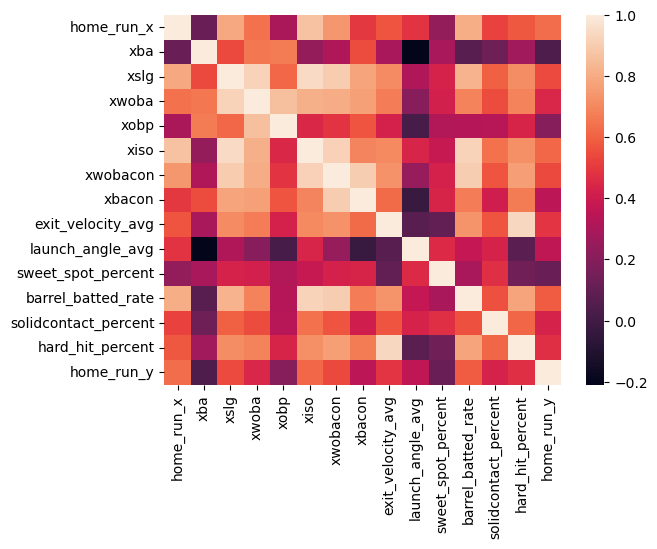

In [11]:
# Heatmap to visualize correlations
sns.heatmap(train_df.iloc[:, 3:36].corr())

[Text(0.5, 1.0, 'Distribtution of HRs in Training Set')]

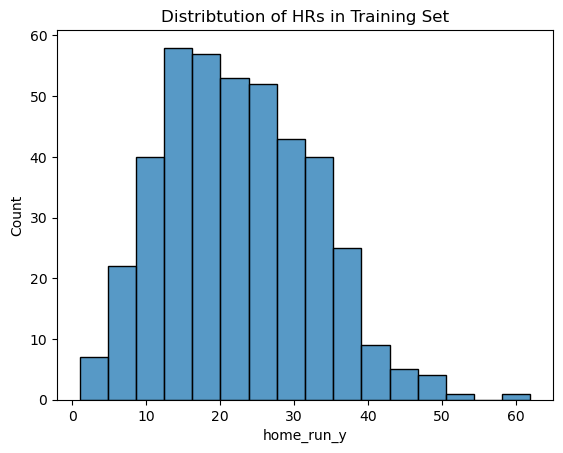

In [12]:
# Distributions of HRs
sns.histplot(train_df['home_run_y']).set(title='Distribtution of HRs in Training Set')

[Text(0.5, 1.0, 'Overall Mean HRs by Year')]

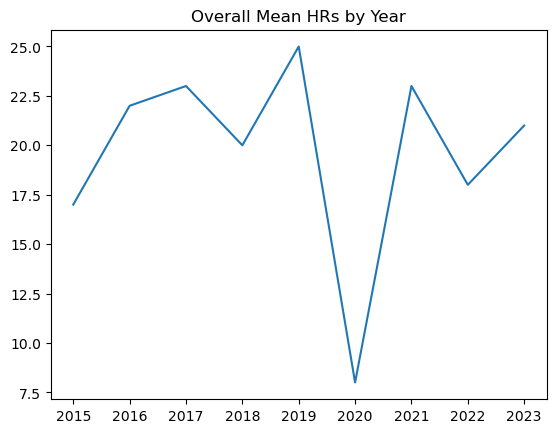

In [13]:
# Plot of Avg HR Per Year
hr_year = []
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
for x in years:
    temp = data[data['year'] == x]
    hr_year.append(temp['home_run'].median())
sns.lineplot(y=hr_year, x= years).set(title='Overall Mean HRs by Year')

## Data Preprocessing

In [14]:
# Feature Extraction with RFE
model = Ridge()
rfe = RFECV(model, cv = 5)
fit = rfe.fit(X_train.iloc[:, 3:36], y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

for feature in fit.support_.nonzero():
      print(X_train.iloc[:, 3:36].columns[feature])

Num Features: 14
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Index(['home_run_x', 'xba', 'xslg', 'xwoba', 'xobp', 'xiso', 'xwobacon',
       'xbacon', 'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', 'hard_hit_percent'],
      dtype='object')


In [15]:
# Create Pipeline
drop_features = ['last_name, first_name', 'player_id', 'year']

numeric_features = ['home_run_x', 'xba', 'xslg', 'xwoba', 'xobp', 'xiso', 'xwobacon', 'xbacon',
       'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', "hard_hit_percent"]

In [16]:
ct = make_column_transformer(
    ("passthrough", numeric_features),
    ("drop", drop_features),
)

In [17]:
transformed = ct.fit_transform(X_train, y_train)

## Model Selection

In [18]:
models = {
    "dummy regressor": DummyRegressor(),
    "KNN regressor":KNeighborsRegressor(),
    "linear regression":LinearRegression(),
    "ridge regression": Ridge(),
    "bayesian ridge regression": BayesianRidge(),
    "LASSO regression": Lasso(),
    "decision tree": DecisionTreeRegressor(),
    "random forest": RandomForestRegressor(random_state = 123, n_jobs = -1),
    "XGBoost": XGBRegressor(random_state = 123, verbosity=0),
    "LGBM":  LGBMRegressor(random_state = 123),
    "CatBoost": CatBoostRegressor(random_state = 123, verbose=0)
}

In [19]:
results_dict = {}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [20]:
scoring = ['neg_mean_absolute_error']
alg = ["dummy regressor", "KNN regressor", "linear regression", "ridge regression", "bayesian ridge regression","LASSO regression",  "decision tree", "random forest", "XGBoost", "LGBM", "CatBoost"]

for i in alg:
    pipe = make_pipeline(
        ct,
        models[i]
    )
    results_dict[i] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score = True, cv = 5, scoring = scoring)

In [21]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error
dummy regressor,0.003 (+/- 0.001),0.002 (+/- 0.000),-8.109 (+/- 0.522),-8.096 (+/- 0.131)
KNN regressor,0.002 (+/- 0.000),0.002 (+/- 0.000),-6.520 (+/- 0.279),-5.339 (+/- 0.127)
linear regression,0.004 (+/- 0.001),0.002 (+/- 0.000),-6.158 (+/- 0.558),-5.856 (+/- 0.118)
ridge regression,0.003 (+/- 0.001),0.002 (+/- 0.000),-6.129 (+/- 0.501),-5.945 (+/- 0.120)
bayesian ridge regression,0.004 (+/- 0.001),0.002 (+/- 0.000),-6.142 (+/- 0.431),-6.005 (+/- 0.107)
LASSO regression,0.003 (+/- 0.000),0.002 (+/- 0.000),-6.209 (+/- 0.440),-6.079 (+/- 0.087)
decision tree,0.005 (+/- 0.000),0.002 (+/- 0.000),-9.058 (+/- 0.634),0.000 (+/- 0.000)
random forest,0.469 (+/- 0.840),0.015 (+/- 0.003),-6.445 (+/- 0.450),-2.428 (+/- 0.047)
XGBoost,0.072 (+/- 0.029),0.003 (+/- 0.000),-6.975 (+/- 0.405),-0.008 (+/- 0.005)
LGBM,0.020 (+/- 0.001),0.002 (+/- 0.000),-6.843 (+/- 0.383),-2.275 (+/- 0.057)


## Evaluating the Test Set

In [22]:
ols_pipe = make_pipeline(ct, LinearRegression())

In [23]:
ols_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['home_run_x', 'xba', 'xslg',
                                                   'xwoba', 'xobp', 'xiso',
                                                   'xwobacon', 'xbacon',
                                                   'exit_velocity_avg',
                                                   'launch_angle_avg',
                                                   'sweet_spot_percent',
                                                   'barrel_batted_rate',
                                                   'solidcontact_percent',
                                                   'hard_hit_percent']),
                                                 ('drop', 'drop',
                                                  ['last_name, first_name',
                                                   'player_id', 'year'])])),
                ('linearregression', LinearRegression())])

In [24]:
# Examining coefficents
model = LinearRegression()
model.fit(X_train[numeric_features], y_train)
pd.DataFrame(zip(numeric_features, model.coef_)).sort_values(1, ascending = False)

,0,1
1,xba,629.141182
5,xiso,588.388076
6,xwobacon,135.163977
3,xwoba,106.582679
8,exit_velocity_avg,0.934949
12,solidcontact_percent,0.427855
9,launch_angle_avg,0.384468
0,home_run_x,0.324476
13,hard_hit_percent,-0.124737
11,barrel_batted_rate,-0.251972


In [25]:
pred = ols_pipe.predict(X_test)

In [26]:
mean_absolute_error(y_test, pred)

5.600027099015987

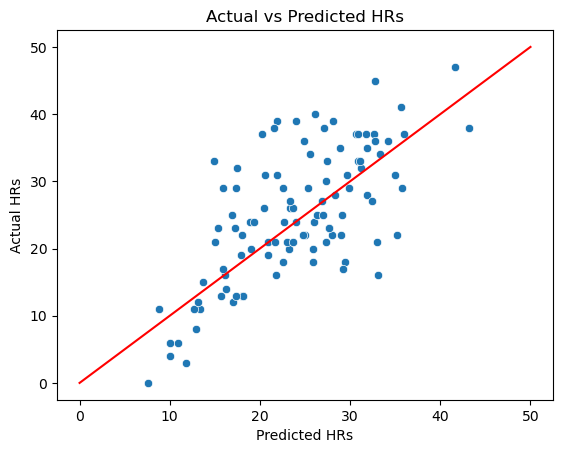

In [27]:
# Visualizing Actual vs Predicted HRs

g = sns.scatterplot(x=pred, y=y_test).set(title='Actual vs Predicted HRs')

plt.plot(np.linspace(0, 50, 100), np.linspace(0, 50, 100), color='r')
plt.xlabel("Predicted HRs")
plt.ylabel("Actual HRs")
plt.show()

[Text(0.5, 1.0, 'Prediction Error')]

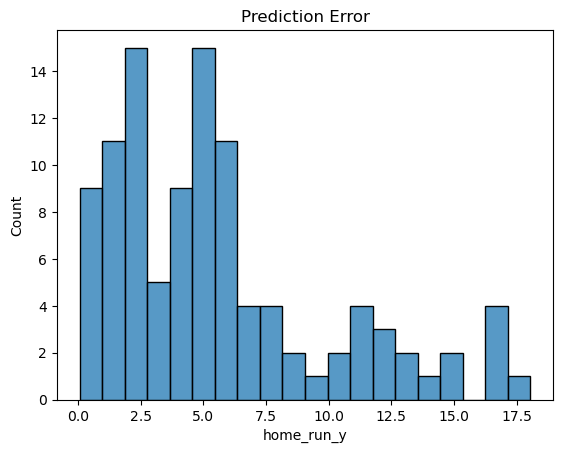

In [28]:
# Visualize Error
sns.histplot(abs(y_test-pred), bins = 20).set(title="Prediction Error")

In [29]:
# See Summary Metrics of Errors
results2022= pd.DataFrame()
results2022['Diff'] = abs(y_test-(pred))
results2022['Diff'].describe()

count    105.000000
mean       5.600027
std        4.437054
min        0.052720
25%        2.205048
50%        4.867894
75%        6.955246
max       18.056911
Name: Diff, dtype: float64

# 2023 Predictions

In [30]:
new_test = data_2023.rename(columns={"home_run": "home_run_x"})

In [31]:
# See Projections
pred_2023 = ols_pipe.predict(new_test)
data_2023_2 = data_2023

pd.options.mode.chained_assignment = None 
data_2023_2['HR_Prediction'] = pred_2023
data_2023_2=data_2023_2[['last_name, first_name', 'HR_Prediction', 'home_run']].sort_values('home_run', ascending = False)
data_2023_2=data_2023_2.rename(columns={"last_name, first_name":"Name", "HR_Prediction":"2024_HR_Prediction", "home_run":"2023_HRs"})

In [32]:
data_2023_2.head(20).sort_values('2024_HR_Prediction', ascending =False)

,Name,2024_HR_Prediction,2023_HRs
1157,"Olson, Matt",43.184008,54
1180,"Schwarber, Kyle",39.411479,47
1183,"Ohtani, Shohei",37.879586,44
1159,"Alonso, Pete",36.865983,46
1118,"Ozuna, Marcell",36.228080,40
1127,"Muncy, Max",36.127969,36
1211,"Garcia, Adolis",35.379716,39
1184,"Acuna Jr., Ronald",35.019239,41
1144,"Betts, Mookie",34.221952,39
1160,"Soler, Jorge",33.952740,36


In [33]:
# See Distribution of 2023 vs Predicted 2024 
data_2023_2.describe()

,2024_HR_Prediction,2023_HRs
count,133.000000,133.000000
mean,22.795989,21.827068
std,6.776915,9.584956
min,8.009772,1.000000
25%,17.613226,15.000000
50%,22.507198,21.000000
75%,26.476430,26.000000
max,43.184008,54.000000


In [34]:
# Obtained Final Leaderboard
data_2023_2['2024_HR_Prediction'] = data_2023_2['2024_HR_Prediction'].round()
final_leaderboard = data_2023_2[['Name','2024_HR_Prediction']].sort_values("2024_HR_Prediction", ascending =False)
final_leaderboard.head()

,Name,2024_HR_Prediction
1157,"Olson, Matt",43.0
1180,"Schwarber, Kyle",39.0
1183,"Ohtani, Shohei",38.0
1159,"Alonso, Pete",37.0
1118,"Ozuna, Marcell",36.0


In [35]:
# Save Leaderboard as CSV
final_leaderboard.to_csv("output/Predicted_2024_HR_Leaderboard.csv",index=False)